In [136]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
"""
packages for dataload and simulation
"""
import ffn # data access
from arch import arch_model  # simulation
from arch.univariate import SkewStudent, GARCH, EGARCH, ARX
"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

import codelib  # used for extending pandas
from codelib.stats import weighted_kurtosis, weighted_skew, weighted_mean, weighted_variance
from codelib.plotting import dist_vs_normal_plot, volume_contribution_plot, DefaultStyle, default_colors
sns.set_theme("paper","whitegrid")
DefaultStyle()
"""
ignore warnings
"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and manipulate data

## Modelling and simulation

In [3]:
n_time_points = 525
prices = ffn.get('spy', start = '2010-01-01', end = '2020-01-01')

returns = prices.to_returns().dropna()
rs = np.random.RandomState([1])
dist = SkewStudent()
vol = GARCH()  # EGARCH()
lag = [1]  # [1, 2, 3, 4, 5]

am = ARX(returns * 100, lags=lag, volatility=vol, distribution=dist)
am_params = am.fit().params



Iteration:      1,   Func. Count:      9,   Neg. LLF: 103663.40579830503
Iteration:      2,   Func. Count:     22,   Neg. LLF: 127045.33479414729
Iteration:      3,   Func. Count:     33,   Neg. LLF: 111516.30540739962
Iteration:      4,   Func. Count:     43,   Neg. LLF: 55847.3929310931
Iteration:      5,   Func. Count:     52,   Neg. LLF: 4089.5678434647175
Iteration:      6,   Func. Count:     61,   Neg. LLF: 4848.618074219387
Iteration:      7,   Func. Count:     70,   Neg. LLF: 7734.416021500073
Iteration:      8,   Func. Count:     80,   Neg. LLF: 2894.870151440159
Iteration:      9,   Func. Count:     89,   Neg. LLF: 62558.06076721722
Iteration:     10,   Func. Count:     99,   Neg. LLF: 2892.949388850873
Iteration:     11,   Func. Count:    107,   Neg. LLF: 2892.9446765773164
Iteration:     12,   Func. Count:    115,   Neg. LLF: 2892.9441150399834
Iteration:     13,   Func. Count:    123,   Neg. LLF: 2892.9440673586187
Iteration:     14,   Func. Count:    130,   Neg. LLF: 2892

In [117]:
all_sims = (am.simulate(params=am_params, nobs=(n_time_points + 100)) / 100)["data"].values
n_episodes = 100

for episode in range(n_episodes):
    sim_i = (am.simulate(params=am_params, nobs=(n_time_points + 100)) / 100)["data"].values
    all_sims = np.vstack((all_sims, sim_i))
    j = (episode + 1) / n_episodes
    sys.stdout.write('\r\r\r\r'.center(65))
    sys.stdout.write(f"EPISODE {episode} - %d%%".center(65) % (100*j))
    sys.stdout.flush()



                                                      EPISODE 99 - 100%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

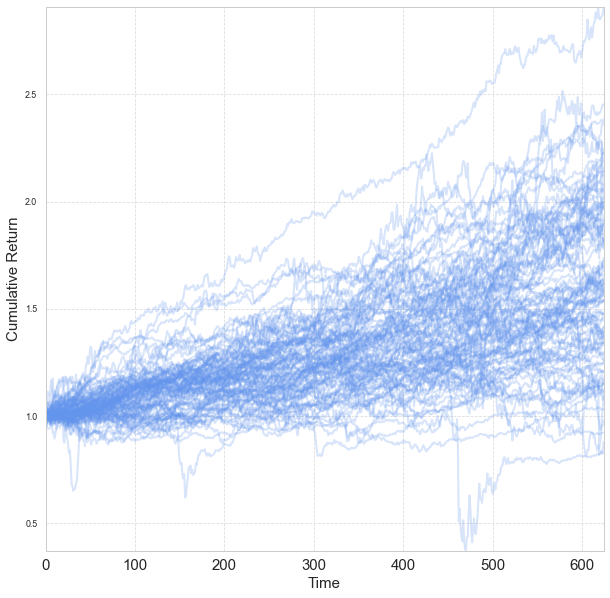

In [145]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot((1 + all_sims).cumprod(axis = 1).T, color = "cornflowerblue", alpha = 0.25)
#ax.set(xlabel = "Return")
ax.set_xlabel("Time", fontsize = 15)
ax.set_ylabel("Cumulative Return", fontsize = 15)
plt.xticks(fontsize=15)
#plt.savefig("plots/garch_sim.png")

In [116]:
df = pd.DataFrame(all_sims).T
df2 = pd.DataFrame(columns = ["return", "simulation"])
df2 = pd.DataFrame({"return": df.iloc[:, 0], "simulation": 0})
for j in range(df.shape[1]-1):
    df2 = df2.append(pd.DataFrame({"return": df.iloc[:, j+1], "simulation": j+1}))
kurt1 = 0
skew1 = 0
for j in range(all_sims.shape[0]):
    kurt1 += weighted_kurtosis(all_sims[j, :], wts = np.ones_like(all_sims[j, :])) / all_sims.shape[0]
    skew1 += weighted_skew(all_sims[j, :], wts = np.ones_like(all_sims[j, :])) / all_sims.shape[0]
    
print(kurt1)
print(skew1)

10.10467528454152
-0.4306031038007136


In [111]:
n_obs = 50

df3 = df2[df2["simulation"] < n_obs]
#df3["simulation"] = df3["simulation"].values + 1
df3.reset_index(drop = True, inplace = True)

kurt1 = 0
skew1 = 0
std1 = np.std(all_sims[:n_obs, :], axis = 1).mean()
mean1 = np.average(all_sims[:n_obs, :], axis = 1).mean()
for j in range(n_obs):
    kurt1 += weighted_kurtosis(all_sims[j, :], wts = np.ones_like(all_sims[j, :])) / n_obs
    skew1 += weighted_skew(all_sims[j, :], wts = np.ones_like(all_sims[j, :])) / n_obs

In [65]:
kurt1

12.525247305351765

In [127]:
returns.reset_index(drop = True, inplace = True)

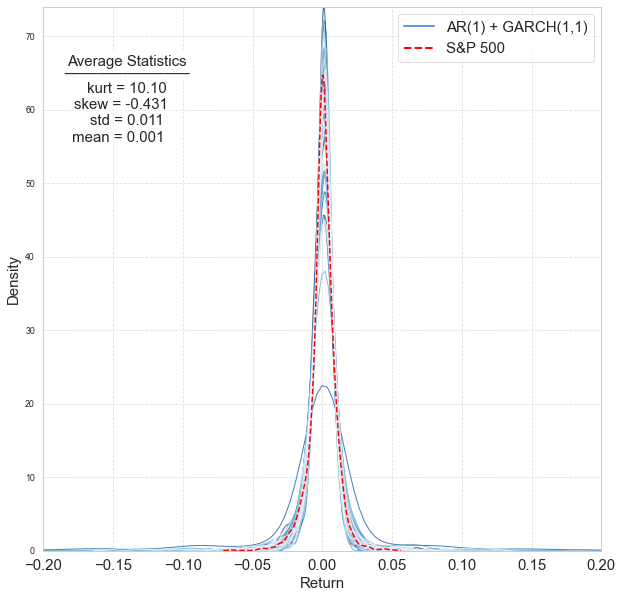

In [143]:
loc = (0.15, 0.85)
fig, ax = plt.subplots(figsize = (10, 10))
sns.kdeplot(data = df3, x = "return", hue = "simulation", common_norm = False, 
            palette = "Blues", alpha = 0.75, fill = False, linewidth = 1, ax = ax, label = None)
sns.kdeplot(data = returns, x = "spy", color = "red", ls = "--", alpha = 1, fill = False, linewidth = 1.5,
            ax = ax, label = None)


ax.text(loc[0] , loc[1] + 0.038, f"_______________", horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=1))
ax.text(loc[0], loc[1], f"kurt = {kurt1:.2f}", horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax.text(loc[0]- 0.01, loc[1] - 0.03, f"skew = {skew1:.3f}", horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.25))
ax.text(loc[0] , loc[1] + 0.05, f"Average Statistics", horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=1))
ax.text(loc[0]- 0.00, loc[1] - 0.06, f"std = {std1:.3f}", horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.25))
ax.text(loc[0]- 0.015, loc[1] - 0.09, f"mean = {mean1:.3f}", horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.25))

custom_lines = [Line2D([0], [0], color="cornflowerblue", lw=2),
                Line2D([0], [0], color="red", lw=2, ls = "--")]


ax.legend(custom_lines, ['AR(1) + GARCH(1,1)', 'S&P 500'])
ax.set_xlim(-0.2, 0.2)
#ax.set(xlabel = "Return")
ax.set_xlabel("Return", fontsize = 15)
ax.set_ylabel("Density", fontsize = 15)
plt.xticks(fontsize=15)
#plt.savefig("plots/garch_densities.png")